# PANEL 2012-2019 DE DELITOS COMETIDOS EN LA CIUDAD DE VALLEDUPAR

A nivel de delito cometido. El presente script es para generar un análisis de lso delitos cometidos en la ciudad de Valledupar 


In [12]:
import pandas as pd 
pd.options.display.max_rows

60

In [13]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

In [14]:
data1 = np.zeros((630000000),dtype=int)

In [15]:
len(data1)

630000000

In [16]:
df=pd.read_csv("delitos_totales.csv", encoding="latin-1")

In [17]:
df.columns

Index(['fecha', 'departamento', 'municipio', 'dia', 'hora', 'barrio', 'zona',
       'clase de sitio', 'arma empleada', 'móvil agresor', 'móvil victima',
       'cantidad', 'tipo'],
      dtype='object')

In [18]:
df["móvil agresor"].unique()

array(['CONDUCTOR MOTOCICLETA', 'VEHICULO', 'CONDUCTOR VEHICULO',
       'PASAJERO METRO', nan, 'CONDUCTOR BUS', 'A PIE',
       'PASAJERO MOTOCICLETA', 'PASAJERO VEHICULO', 'PASAJERO BUS',
       'PASAJERO TAXI', 'CONDUCTOR TAXI', 'NO REPORTADO', 'BICICLETA',
       'PASAJERO AERONAVE', 'MOTO', 'SIN EMPLEO DE ARMAS', 'ESCOPOLAMINA',
       'CONTUNDENTES', 'ARMA BLANCA / CORTOPUNZANTE'], dtype=object)

## 1. PROCESAMIENTO INICIAL

In [19]:
#CAMBIAR LOS NOMBRES DE TIPOS DE DELITOS

for i,e in zip(['HT', 'HA', 'HC', 'HR', 'H', 'HP', 'LT'], ["hom_acc", "hurt_auto", "hurt_comercio", "hurt_residencia", "homicidios", "hur_personas", "les_acc"]):
    df["tipo"]=df["tipo"].replace(i,e)

In [20]:
#FECHA A FORNATO DATETIME
df["fecha"]=pd.to_datetime(df["fecha"])

#DIAS A MINÚSCULAS
df["dia"]=df["dia"].str.lower()

#CREAR COLUMNA DE AÑO-MES
df["año-mes"]=df["fecha"].dt.strftime('%Y-%m')

#CREAR COLUMNAS DE AÑO-SEMANA
df['año-semana'] = df['fecha'].dt.strftime('%Y-%U') # crear año - semana

#DUMMIE SI EL HECHO FUE ANTES O DESPUÉS DE LA POLÍTÍCA: se anunció el 22
df["D"]=df["fecha"].map(lambda x: 1 if x>datetime.strptime("2014-07-26", '%Y-%m-%d').date() else 0)

#DUMMIE SI EL DELITO FUE COMETIDO EN MOTOCICLETE
df["moto"]=df["móvil agresor"].map(lambda x: 1 if x=="CONDUCTOR MOTOCICLETA" or x=="PASAJERO MOTOCICLETA" or x=="MOTO"  else 0) 

#PODER AJUSTAR VENTANA TEMPORAL
df=df[(df["fecha"]>datetime.strptime("2012-07-26", "%Y-%m-%d").date()) & (df["fecha"]<datetime.strptime("2016-07-26", "%Y-%m-%d").date()) ] #Ajustar ventana temporal

In [21]:
#BARRIOS MÁS PELIGROSOS
barrios=df.groupby("barrio")["cantidad"].sum().sort_values(ascending=False).reset_index()

#OBTENER EL P90 DE LOS BARRIOS MAS PELIGROSOS
p90=np.percentile(barrios["cantidad"], 90, axis=0)

#CREAR DUMMIE DE SI EL BARRIO ES O NO PELIGRSOS
barrios["peligroso"]=barrios["cantidad"].apply(lambda x: 1 if x>p90 else 0 )

barrios=barrios[["barrio", "peligroso"]]

#MERGE CON LA BASE PRINCIPAL
df = pd.merge(df, barrios, how="left", on="barrio")

## 2. ANÁLISIS GENERAL

In [22]:
#1. DELITOS ANTES Y DESPUÉS POR TIPO Y DÍA
bef_tipo=df[df["D"]==0].pivot_table(index='tipo', columns='dia', aggfunc={'cantidad':sum}, margins=False).replace(np.nan, 0)

aft_tipo=df[df["D"]==1].pivot_table(index='tipo', columns='dia', aggfunc={'cantidad':sum}, margins=False).replace(np.nan, 0)

aft_bef=df.pivot_table(index='tipo', columns='dia', aggfunc={'cantidad':sum}, margins=False).replace(np.nan, 0)
print("ANTES\n", bef_tipo ,"\n\n", "DESPUÉS\n", aft_tipo, "\n\n VENTANA\n", aft_bef )


ANTES
                 cantidad                                             
dia              domingo jueves lunes martes miércoles sábado viernes
tipo                                                                 
hom_acc               30     17    13     10        10     15      12
homicidios            38     19    19     22        25     29      14
hur_personas         219    282   261    244       263    305     291
hurt_auto             22     32    22     36        37     43      23
hurt_comercio         34     65    77     78        78     65      69
hurt_residencia       87     70    46     66        69     87      84
les_acc              109     63    71     55        48     64      66 

 DESPUÉS
                 cantidad                                             
dia              domingo jueves lunes martes miércoles sábado viernes
tipo                                                                 
hom_acc               16     15    18      9         6     20       6
h

In [23]:
#2. DELITOS ANTES Y DESPUÉS POR TIPO Y DÍA: COMETIDOS EN MOTO

bef_tipo=df[(df["D"]==0) & (df["moto"]==1)].pivot_table(index='tipo', columns='dia', aggfunc={'cantidad':sum}, margins=False).replace(np.nan, 0)
bef_tipo.to_excel("b.xls")
aft_tipo=df[(df["D"]==1) & (df["moto"]==1)].pivot_table(index='tipo', columns='dia', aggfunc={'cantidad':sum}, margins=False).replace(np.nan, 0)
aft_tipo.to_excel("a.xls")
aft_bef=df[(df["moto"]==1)].pivot_table(index='tipo', columns='dia', aggfunc={'cantidad':sum}, margins=False).replace(np.nan, 0)
print("ANTES\n", bef_tipo ,"\n\n", "DESPUÉS\n", aft_tipo, "\n\n VENTANA\n", aft_bef )
aft_bef.to_excel("ba.xls")

ANTES
                 cantidad                                             
dia              domingo jueves lunes martes miércoles sábado viernes
tipo                                                                 
hom_acc              9.0    4.0   5.0    5.0       4.0    8.0     5.0
homicidios           4.0    3.0   4.0    3.0       7.0    4.0     2.0
hur_personas        50.0   80.0  63.0   72.0      59.0   83.0    83.0
hurt_auto            1.0    2.0   0.0    3.0       2.0    2.0     1.0
hurt_comercio        2.0   14.0   6.0    6.0      10.0    9.0     8.0
hurt_residencia      4.0    3.0   1.0    6.0       3.0    5.0     5.0
les_acc             59.0   35.0  33.0   25.0      33.0   38.0    35.0 

 DESPUÉS
                 cantidad                                             
dia              domingo jueves lunes martes miércoles sábado viernes
tipo                                                                 
hom_acc               12      3     2      5         5      8       4
h

# 3.GRÁFICAS

In [13]:
#CEAR SERIES PARA GRÁFICAS

#no sábados - promedio
NS_P=df[df["dia"]!="sábado"].groupby(["año-semana","dia"])["cantidad"].sum().reset_index()
NS_P=NS_P.groupby(["año-semana"])["cantidad"].mean().reset_index()
NS_P["cantidad"] = NS_P["cantidad"].rolling(6).mean()

#no sábados - no miércoles promedio
NSM_P=df[(df["dia"]=="lunes") | (df["dia"]=="martes") | (df["dia"]=="jueves") | (df["dia"]=="viernes") | (df["dia"]=="domingo")].groupby(["año-semana","dia"])["cantidad"].sum().reset_index()
NSM_P=NSM_P.groupby(["año-semana"])["cantidad"].mean().reset_index()
NSM_P["cantidad"] = NSM_P["cantidad"].rolling(6).mean()

#no sábados
resto=df[df["dia"]!="sábado"].groupby(["año-semana"])["cantidad"].sum().reset_index()
resto["cantidad"] = resto["cantidad"].rolling(6).mean()

#no sábados ni miércoles
resto_nm=df[(df["dia"]=="lunes") | (df["dia"]=="martes") | (df["dia"]=="jueves") | (df["dia"]=="viernes") | (df["dia"]=="domingo")].groupby(["año-semana"])["cantidad"].sum().reset_index()
resto_nm["cantidad"] = resto_nm["cantidad"].rolling(6).mean()

#sábados
sabado=df[df["dia"]=="sábado"].groupby(["año-semana"])["cantidad"].sum().reset_index()
sabado["cantidad"] = sabado["cantidad"].rolling(6).mean() #suavizar con media móvil

Text(0.5, 1.0, 'sábados vs Resto de días (no miércoles)')

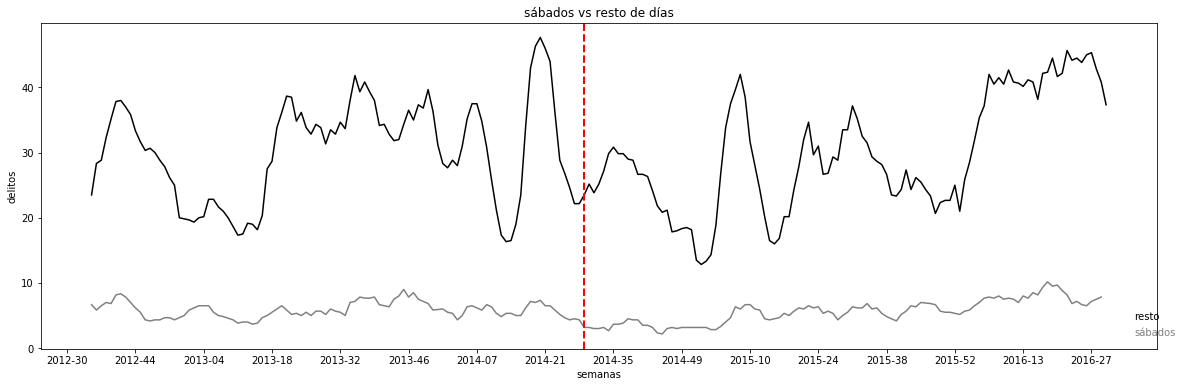

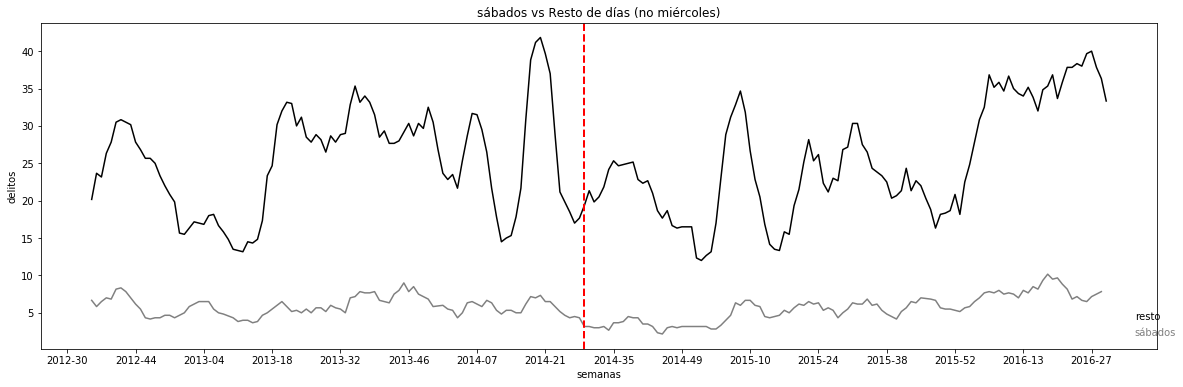

In [14]:
#1
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(resto["año-semana"], resto["cantidad"], color="black")
plt.plot(sabado["año-semana"], sabado["cantidad"], color="gray")
plt.text(0.98, 0.1, 'resto', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="black")
plt.text(0.98, 0.05, 'sábados', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="gray")
ax.set_xticks(ax.get_xticks()[::14])
ax.axvline('2014-29', color='r', linestyle='--', lw=2)
plt.xlabel("semanas")
plt.ylabel("delitos")
plt.title("sábados vs resto de días")

#2
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(resto_nm["año-semana"], resto_nm["cantidad"], color="black")
plt.plot(sabado["año-semana"], sabado["cantidad"], color="gray")
plt.text(0.98, 0.1, 'resto', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="black")
plt.text(0.98, 0.05, 'sábados', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="gray")
ax.set_xticks(ax.get_xticks()[::14])
ax.axvline('2014-29', color='r', linestyle='--', lw=2)
plt.xlabel("semanas")
plt.ylabel("delitos")
plt.title("sábados vs Resto de días (no miércoles)")

Text(0.5, 1.0, 'sábados vs media de resto de días (no miércoles)')

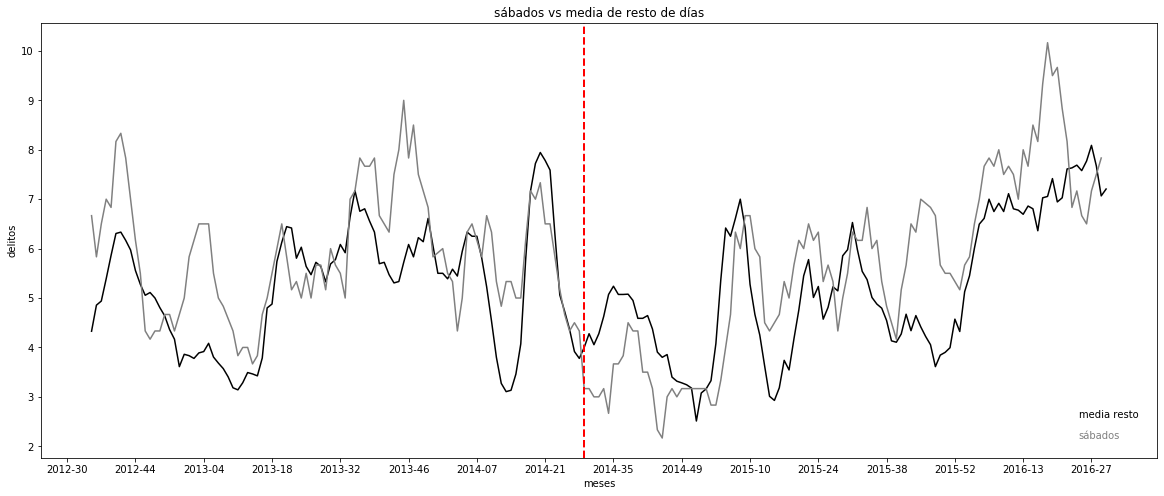

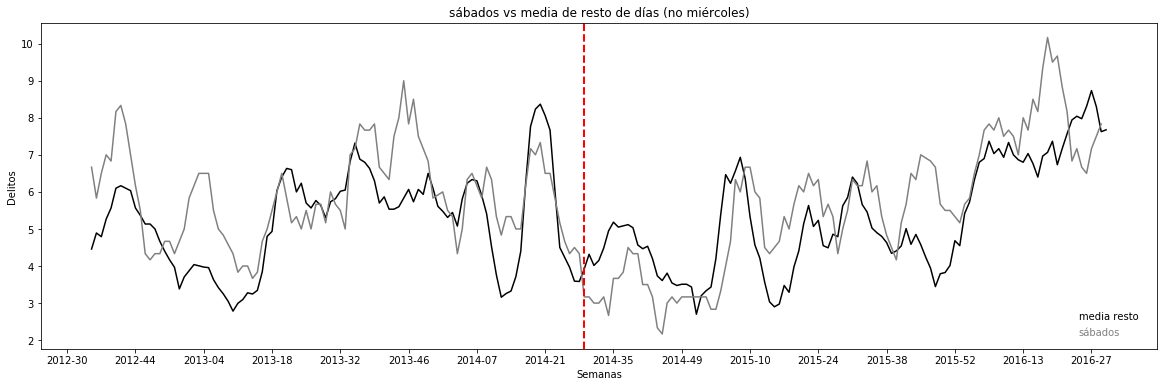

In [16]:
#1
fig, ax = plt.subplots(figsize=(20,8))
plt.plot(NS_P["año-semana"], NS_P["cantidad"], color="black")
plt.plot(sabado["año-semana"], sabado["cantidad"], color="gray")
plt.text(0.93, 0.1, 'media resto', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="black")
plt.text(0.93, 0.05, 'sábados', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="gray")
ax.set_xticks(ax.get_xticks()[::14])
ax.axvline('2014-29', color='r', linestyle='--', lw=2)
plt.xlabel("meses")
plt.ylabel("delitos")
plt.title("sábados vs media de resto de días")

#2
fig, ax = plt.subplots(figsize=(20,6))
plt.plot(NSM_P["año-semana"], NSM_P["cantidad"], color="black")
plt.plot(sabado["año-semana"], sabado["cantidad"], color="gray")
plt.text(0.93, 0.1, 'media resto', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="black")
plt.text(0.93, 0.05, 'sábados', horizontalalignment='left',verticalalignment='center', transform=ax.transAxes, color="gray")
ax.set_xticks(ax.get_xticks()[::14])
ax.axvline('2014-29', color='r', linestyle='--', lw=2)
plt.xlabel("Semanas")
plt.ylabel("Delitos")
plt.title("sábados vs media de resto de días (no miércoles)")

# 4. PREPARACIÓN DE LA BASE

In [194]:
#1.CONVERTIR LA BASE DE DELITOS A DELITOS POR DÍA
general=df.groupby(["fecha"])["cantidad"].sum().reset_index()

#2.CREAR UN ESQUELETO DE LA VENTANA ANTERIOR YA QUE HAY DIAS (POCOS, QUE NO TIENEN NINGUN DELITO)
ventana_c=pd.date_range("2012-07-27", "2016-07-25").to_series().reset_index()
ventana_c=ventana.rename(columns={"index":"index", 0:"fecha"})

#crear la columna de días
ventana_c["dia"]=ventana_c["fecha"].map(lambda x: x.strftime("%A"))
for i,e in zip(['Friday', 'Saturday', 'Monday', 'Tuesday', 'Thursday', 'Sunday','Wednesday'], ["viernes", "sábado", "lunes", "martes", "jueves", "domingo", "miércoles"]):
    ventana_c["dia"]=ventana_c["dia"].replace(i, e)
ventana_c.drop(columns="index", inplace=True)

#3. MERGE DE LA BASE 2 CON LA 1
db=pd.merge(ventana_c, general , how="left", on="fecha").replace(np.nan, 0)

In [196]:
#CREAR COLUMNAS IMPORTANTES PARA LA REGRESIÓN

#Quiero efectos fijos de mes y de día
db["n_year"]=db["fecha"].dt.year

#MES
db["n_month"]=db["fecha"].dt.month

#NÚMERO DE DÍA
db["n_day"]=db["dia"]
for i,e in zip(["lunes","martes","miércoles","jueves","viernes","sábado","domingo"], [1,2,3,4,5,6,7]):
    db["n_day"]=db["n_day"].replace(i,e)



#DUMMIE SI EL HECHO FUE ANTES O DESPUÉS DE LA POLÍTÍCA: se anunció el 22
db["D"]=db["fecha"].map(lambda x: 1 if x>datetime.strptime("2014-07-26", '%Y-%m-%d').date() else 0)

#DUMMIE EI EL HECHO FUE EL SABADO
db["S"]=db["dia"].map(lambda x: 1 if x=="sábado" else 0)



#PLACEBOS ANTES

#DUMMIE SI PLACEBO (2 MESES ANTES)
db["D_1"]=db["fecha"].map(lambda x: 1 if x>datetime.strptime("2014-05-26", '%Y-%m-%d').date() else 0)

#DUMMIE SI PLACEBO (4 MESES ANTES)
db["D_2"]=db["fecha"].map(lambda x: 1 if x>datetime.strptime("2014-03-26", '%Y-%m-%d').date() else 0)

#DUMMIE SI PLACEBO (6 MESES ANTES)
db["D_3"]=db["fecha"].map(lambda x: 1 if x>datetime.strptime("2014-01-26", '%Y-%m-%d').date() else 0)



#PLACEBOS DESPUÉS

#DUMMIE SI PLACEBO (2 MESES DESPUÉS)
db["D1"]=db["fecha"].map(lambda x: 1 if x>datetime.strptime("2014-09-26", '%Y-%m-%d').date() else 0)

#DUMMIE SI PLACEBO (4 MESES DESPUÉS)
db["D2"]=db["fecha"].map(lambda x: 1 if x>datetime.strptime("2014-11-26", '%Y-%m-%d').date() else 0)

#DUMMIE SI PLACEBO (6 MESES DESPUÉS)
db["D3"]=db["fecha"].map(lambda x: 1 if x>datetime.strptime("2015-01-26", '%Y-%m-%d').date() else 0)




#INTERACCIONES

#DUMMIE SI EL HECHO FUE ANTES O DESPUÉS DE LA POLÍTÍCA: se anunció el 22
db["SD"]=db["D"]*db["S"]


#PLACEBOS ANTES

#DUMMIE SI PLACEBO (2 MESES ANTES)
db["SD_1"]=db["D_1"]*db["S"]

#DUMMIE SI PLACEBO (4 MESES ANTES)
db["SD_2"]=db["D_2"]*db["S"]

#DUMMIE SI PLACEBO (6 MESES ANTES)
db["SD_3"]=db["D_3"]*db["S"]


#PLACEBOS DESPUÉS

#DUMMIE SI PLACEBO (2 MESES DESPUÉS)
db["SD1"]=db["D1"]*db["S"]

#DUMMIE SI PLACEBO (4 MESES DESPUÉS)
db["SD2"]=db["D2"]*db["S"]

#DUMMIE SI PLACEBO (6 MESES DESPUÉS)
db["SD3"]=db["D3"]*db["S"]


In [197]:
db

,fecha,dia,cantidad,n_year,n_month,n_day,D,S,D_1,D_2,...,D1,D2,D3,SD,SD_1,SD_2,SD_3,SD1,SD2,SD3
0,2012-07-27,viernes,2.0,2012,7,5,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-07-28,sábado,12.0,2012,7,6,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-07-29,domingo,8.0,2012,7,7,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-07-30,lunes,6.0,2012,7,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-07-31,martes,7.0,2012,7,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,2016-07-21,jueves,6.0,2016,7,4,1,0,1,1,...,1,1,1,0,0,0,0,0,0,0
1456,2016-07-22,viernes,8.0,2016,7,5,1,0,1,1,...,1,1,1,0,0,0,0,0,0,0
1457,2016-07-23,sábado,7.0,2016,7,6,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
1458,2016-07-24,domingo,5.0,2016,7,7,1,0,1,1,...,1,1,1,0,0,0,0,0,0,0


In [198]:
db.to_stata("db.dta", encoding="latin-1")

reg cantidad 